
# Бустинг вручную


In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
X = load_npz('x.npz')
y = np.load('y.npy')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2


In [ ]:
from __future__ import annotations
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from typing import Optional

def score(clf, X, y):
    return roc_auc_score(y == 1, clf.predict_proba(X)[:, 1])

class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.models: list = []
        self.gammas: list = []
        self.learning_rate: float = learning_rate
        self.history = defaultdict(list)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def partial_fit(self, X, y):
        residuals = -self.loss_derivative(y, self.predict_proba(X)[:, 1] - 0.5)

        model = self.base_model_class(**self.base_model_params)
        model.fit(X, residuals)
        predictions = model.predict(X)

        gamma = self.find_optimal_gamma(y, self.predict_proba(X)[:, 1], predictions)

        self.models.append(model)
        self.gammas.append(gamma)

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        y_train = 2 * y_train - 1
        if y_val is not None:
            y_val = 2 * y_val - 1

        train_predictions = np.zeros(y_train.shape[0])
        val_predictions = np.zeros(y_val.shape[0]) if X_val is not None else None

        for i in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions += self.gammas[-1] * self.models[-1].predict(X_train)
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions += self.gammas[-1] * self.models[-1].predict(X_val)
                self.history["val_loss"].append(self.loss_fn(y_val, val_predictions))
                self.history["val_roc_auc"].append(roc_auc_score(y_val == 1, self.sigmoid(val_predictions)))

        if plot:
            self.plot_history()

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])

        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(X)

        probabilities = self.sigmoid(predictions)
        return np.vstack([1 - probabilities, probabilities]).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        plt.figure(figsize=(12, 6))

        for key in self.history.keys():
            plt.plot(self.history[key], label=key)

        plt.xlabel("Iteration")
        plt.ylabel("Metric")
        plt.title("Training History")
        plt.legend()
        plt.show()



### Проверка кода

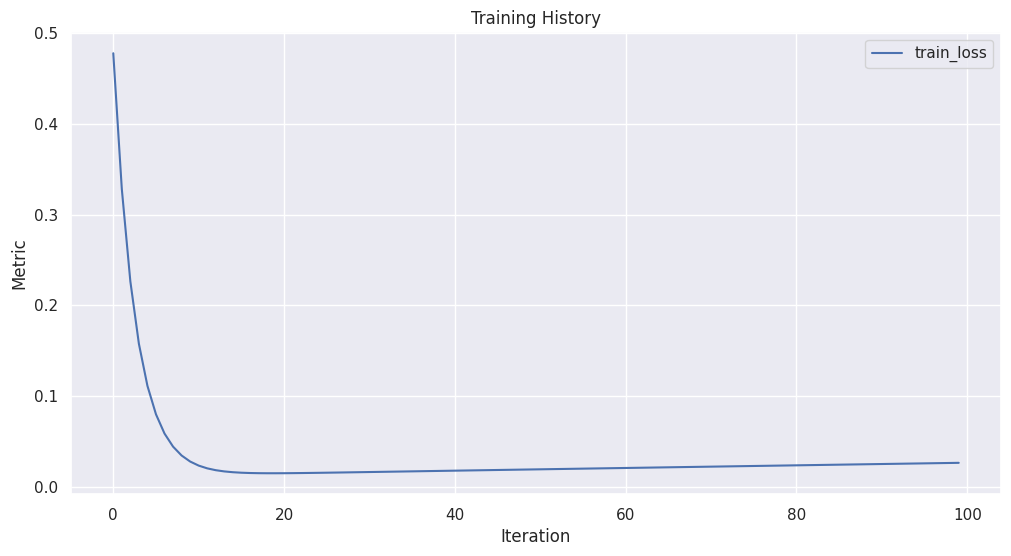

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8752
Test ROC-AUC 0.8638


In [ ]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Гиперпараметры
Критерий останова

Early stopping at iteration 4. Best iteration: 2


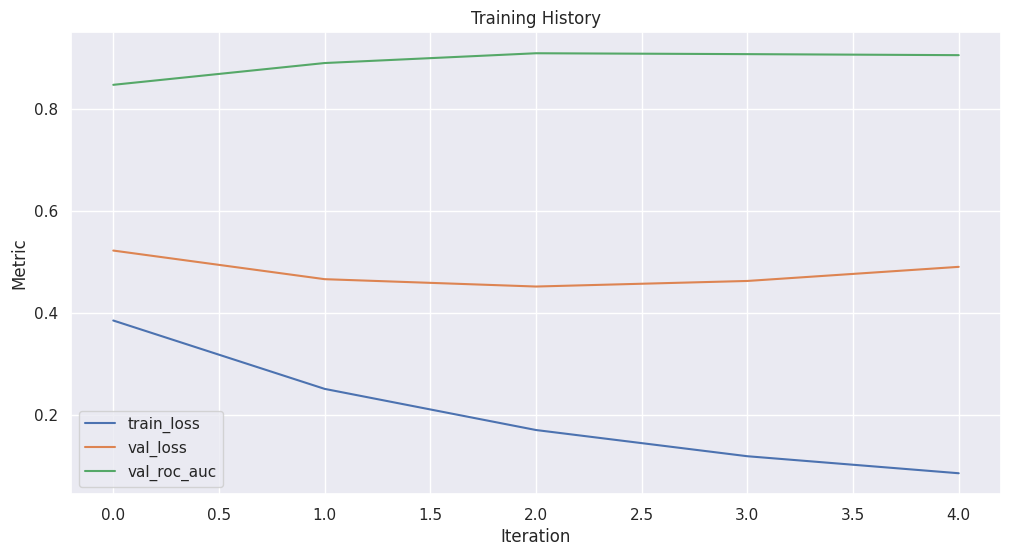

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9091
Test ROC-AUC 0.9011


In [ ]:
from __future__ import annotations
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from typing import Optional, Tuple

def score(clf, X, y):
    return roc_auc_score(y == 1, clf.predict_proba(X)[:, 1])

class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.models: list = []
        self.gammas: list = []
        self.learning_rate: float = learning_rate
        self.early_stopping_rounds: Optional[int] = early_stopping_rounds

        self.history = defaultdict(list)
        self.best_iteration = None
        self.best_model = None

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def partial_fit(self, X, y):
        y = 2 * y - 1
        residuals = -self.loss_derivative(y, self.predict_proba(X)[:, 1] - 0.5)

        model = self.base_model_class(**self.base_model_params)
        model.fit(X, residuals)
        predictions = model.predict(X)

        gamma = self.find_optimal_gamma(y, self.predict_proba(X)[:, 1], predictions)

        self.models.append(model)
        self.gammas.append(gamma)

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        y_train = 2 * y_train - 1
        if y_val is not None:
            y_val = 2 * y_val - 1
        train_predictions = np.zeros(y_train.shape[0])
        val_predictions = np.zeros(y_val.shape[0]) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for i in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions += self.gammas[-1] * self.models[-1].predict(X_train)
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions += self.gammas[-1] * self.models[-1].predict(X_val)
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)
                self.history["val_roc_auc"].append(roc_auc_score(y_val == 1, self.sigmoid(val_predictions)))

                if val_loss <= best_val_loss:
                    best_val_loss = val_loss
                    self.best_iteration = i
                    self.best_model = (list(self.models), list(self.gammas))
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds is not None and rounds_without_improvement >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {i}. Best iteration: {self.best_iteration}")
                    self.models, self.gammas = self.best_model
                    break

        if plot:
            self.plot_history(X_val, y_val)

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])

        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(X)

        probabilities = self.sigmoid(predictions)
        return np.vstack([1 - probabilities, probabilities]).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        plt.figure(figsize=(12, 6))

        for key in self.history.keys():
            plt.plot(self.history[key], label=key)

        plt.xlabel("Iteration")
        plt.ylabel("Metric")
        plt.title("Training History")
        plt.legend()
        plt.show()

boosting = Boosting(n_estimators=100, early_stopping_rounds=2)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score


start_time = time.time()

start_time = time.time()
xgb_model = xgb.XGBClassifier(
    booster="gblinear",
    n_estimators=50,
    learning_rate=0.1,
    random_state=42,
    eval_metric="logloss"
)
history = xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)
xgb_time = time.time() - start_time

y_test_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_test_loss = log_loss(y_test, y_test_pred_xgb)
xgb_test_accuracy = accuracy_score(y_test, (y_test_pred_xgb > 0.5).astype(int))

xgb_loss = xgb_model.evals_result()["validation_0"]["logloss"]
sgd_model = SGDClassifier(loss="log_loss", max_iter=50, random_state=42, learning_rate="constant", eta0=0.01)
sgd_loss_train = []
sgd_loss_val = []

start_time = time.time()
for epoch in range(50):
    sgd_model.partial_fit(X_train, y_train, classes=np.unique(y))
    y_pred_train = sgd_model.predict_proba(X_train)[:, 1]
    y_pred_val = sgd_model.predict_proba(X_valid)[:, 1]
    sgd_loss_train.append(log_loss(y_train, y_pred_train))
    sgd_loss_val.append(log_loss(y_valid, y_pred_val))
sgd_time = time.time() - start_time

y_test_pred_sgd = sgd_model.predict_proba(X_test)[:, 1]
sgd_test_loss = log_loss(y_test, y_test_pred_sgd)
sgd_test_accuracy = accuracy_score(y_test, (y_test_pred_sgd > 0.5).astype(int))

plt.figure(figsize=(10, 6))
plt.plot(xgb_loss, label="XGBoost Validation Loss", linestyle="--")
plt.plot(sgd_loss_train, label="SGD Train Loss")
plt.plot(sgd_loss_val, label="SGD Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Log Loss Comparison")
plt.legend()
plt.grid()
plt.show()

print(f"XGBoost Training Time: {xgb_time:.2f} seconds")
print(f"SGDClassifier Training Time: {sgd_time:.2f} seconds")

print(f"XGBoost Test Log Loss: {xgb_test_loss:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")
print(f"SGDClassifier Test Log Loss: {sgd_test_loss:.4f}")
print(f"SGDClassifier Test Accuracy: {sgd_test_accuracy:.4f}")


XGBoost Training Time: 1.95 seconds

SGDClassifier Training Time: 2.68 seconds

XGBoost Test Log Loss: 0.3105

XGBoost Test Accuracy: 0.8691

SGDClassifier Test Log Loss: 0.3201

SGDClassifier Test Accuracy: 0.8708

качество модели улучшилось, но по графику val_loss видно, что происходит оверфитинг модели

Сравним с `sklearn.linear_model.SGDClassifier`


Оба метода показывают схожие результаты на тестовых данных. Бустинг работает быстрее и быстрее сходится.


### Бутстрап

In [ ]:
class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
        subsample: float = 1.0,
        bagging_temperature: float = 1.0,
        bootstrap_type: str = 'Bernoulli',
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.models: list = []
        self.gammas: list = []
        self.learning_rate: float = learning_rate
        self.early_stopping_rounds: Optional[int] = early_stopping_rounds
        self.subsample: float = subsample
        self.bagging_temperature: float = bagging_temperature
        self.bootstrap_type: str = bootstrap_type

        self.history = defaultdict(list)
        self.best_iteration = None
        self.best_model = None

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _create_bootstrap_sample(self, X, y):
        n_samples = X.shape[0]

        if self.bootstrap_type == 'Bernoulli':
            mask = np.random.rand(n_samples) < self.subsample
            return X[mask], y[mask]

        else:
            weights = (-np.log(np.random.rand(n_samples))) ** self.bagging_temperature
            if hasattr(X, 'multiply'):
                X_weighted = X.multiply(weights[:, np.newaxis])
            else:
                X_weighted = X * weights[:, np.newaxis]

            y_weighted = y * weights
            return X_weighted, y_weighted

    def partial_fit(self, X, y):
        X_bootstrap, y_bootstrap = self._create_bootstrap_sample(X, y)

        residuals = -self.loss_derivative(y_bootstrap, self.predict_proba(X_bootstrap)[:, 1] - 0.5)

        model = self.base_model_class(**self.base_model_params)
        model.fit(X_bootstrap, residuals)
        predictions = model.predict(X_bootstrap)

        gamma = self.find_optimal_gamma(y_bootstrap, self.predict_proba(X_bootstrap)[:, 1], predictions)

        self.models.append(model)
        self.gammas.append(gamma)

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        y_train = 2 * y_train - 1
        if y_val is not None:
            y_val = 2 * y_val - 1
        train_predictions = np.zeros(y_train.shape[0])
        val_predictions = np.zeros(y_val.shape[0]) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for i in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions += self.gammas[-1] * self.models[-1].predict(X_train)
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions += self.gammas[-1] * self.models[-1].predict(X_val)
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)
                self.history["val_roc_auc"].append(roc_auc_score(y_val == 1, self.sigmoid(val_predictions)))

                if val_loss <= best_val_loss:
                    best_val_loss = val_loss
                    self.best_iteration = i
                    self.best_model = (list(self.models), list(self.gammas))
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds is not None and rounds_without_improvement >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {i}. Best iteration: {self.best_iteration}")
                    self.models, self.gammas = self.best_model
                    break

        if plot:
            self.plot_history(X_val, y_val)

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])

        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(X)

        probabilities = self.sigmoid(predictions)
        return np.vstack([1 - probabilities, probabilities]).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        plt.figure(figsize=(12, 6))

        for key in self.history.keys():
            plt.plot(self.history[key], label=key)

        plt.xlabel("Iteration")
        plt.ylabel("Metric")
        plt.title("Training History")
        plt.legend()
        plt.show()


Early stopping at iteration 9. Best iteration: 4


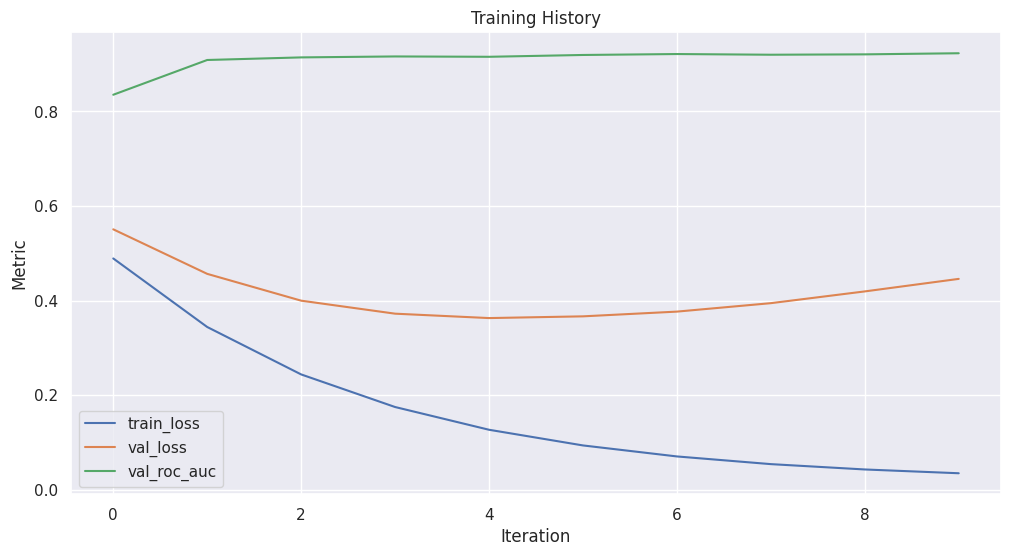

Train ROC-AUC 0.9996
Valid ROC-AUC 0.9155
Test ROC-AUC 0.9145


In [ ]:
boosting = Boosting(n_estimators=100, early_stopping_rounds=5, subsample=0.8, bootstrap_type='Bernoulli')

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')


Early stopping at iteration 10. Best iteration: 5


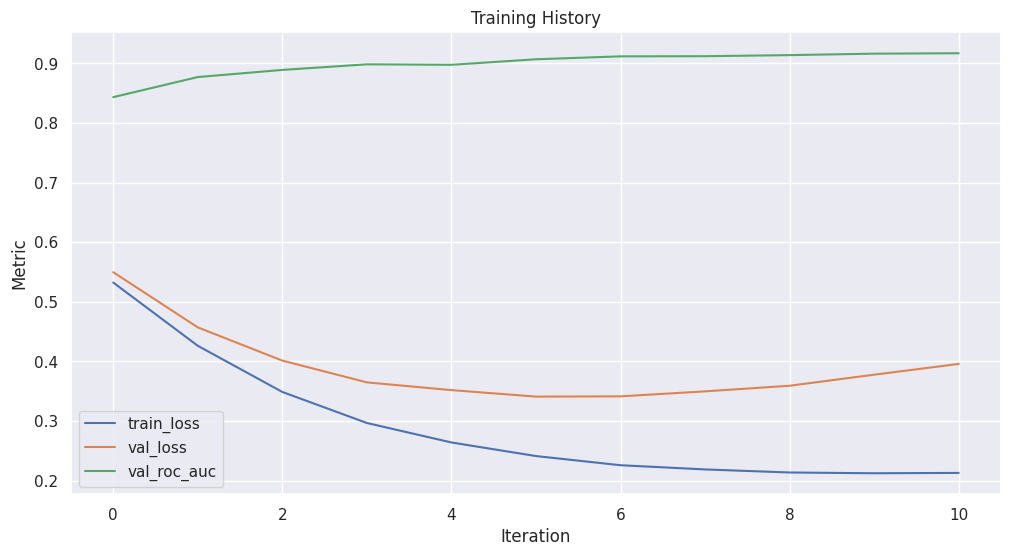

Train ROC-AUC 0.9611
Valid ROC-AUC 0.9071
Test ROC-AUC 0.9119


In [ ]:
boosting = Boosting(n_estimators=100, early_stopping_rounds=5, bagging_temperature=0.8, bootstrap_type='Bayesian')

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')


###  GOSS

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from typing import Optional

class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
        subsample: float = 1.0,
        bagging_temperature: float = 1.0,
        bootstrap_type: str = 'Bernoulli',
        goss: bool = False,
        goss_k: float = 0.2,
        goss_subsample: float = 0.3,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.models: list = []
        self.gammas: list = []
        self.learning_rate: float = learning_rate
        self.early_stopping_rounds: Optional[int] = early_stopping_rounds
        self.subsample: float = subsample
        self.bagging_temperature: float = bagging_temperature
        self.bootstrap_type: str = bootstrap_type

        self.goss: bool = goss
        self.goss_k: float = goss_k
        self.goss_subsample: float = goss_subsample

        self.history = defaultdict(list)
        self.best_iteration = None
        self.best_model = None

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _create_bootstrap_sample(self, X, y, residuals):
        n_samples = X.shape[0]

        if self.goss:
            grad_magnitudes = np.abs(residuals)

            threshold = np.percentile(grad_magnitudes, (1 - self.goss_k) * 100)

            large_idx = grad_magnitudes >= threshold
            small_idx = ~large_idx

            small_sample_size = int(self.goss_subsample * small_idx.sum())
            if small_sample_size > 0:
                small_idx = np.random.choice(np.where(small_idx)[0], small_sample_size, replace=False)
                selected_idx = np.hstack([np.where(large_idx)[0], small_idx])
                weights = np.ones(len(selected_idx))
                weights[len(np.where(large_idx)[0]):] *= len(small_idx) / small_sample_size
            else:
                selected_idx = np.where(large_idx)[0]
                weights = np.ones(len(selected_idx))

            X_sampled = X[selected_idx]
            y_sampled = y[selected_idx]
            residuals_sampled = residuals[selected_idx] * weights
            return X_sampled, y_sampled, residuals_sampled
        else:
            if self.bootstrap_type == 'Bernoulli':
                mask = np.random.rand(n_samples) < self.subsample
                return X[mask], y[mask], residuals[mask]

            else:
                weights = (-np.log(np.random.rand(n_samples))) ** self.bagging_temperature
                if hasattr(X, 'multiply'):
                    X_weighted = X.multiply(weights[:, np.newaxis])
                else:
                    X_weighted = X * weights[:, np.newaxis]

                y_weighted = y * weights
                residuals_weighted = residuals * weights
                return X_weighted, y_weighted, residuals_weighted


    def partial_fit(self, X, y):
        predictions = self.predict_proba(X)[:, 1] - 0.5
        residuals = -self.loss_derivative(y, predictions)

        X_bootstrap, y_bootstrap, residuals_bootstrap = self._create_bootstrap_sample(X, y, residuals)

        model = self.base_model_class(**self.base_model_params)
        model.fit(X_bootstrap, residuals_bootstrap)
        predictions = model.predict(X_bootstrap)

        gamma = self.find_optimal_gamma(y_bootstrap, self.predict_proba(X_bootstrap)[:, 1], predictions)

        self.models.append(model)
        self.gammas.append(gamma)

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        y_train = 2 * y_train - 1
        if y_val is not None:
            y_val = 2 * y_val - 1
        train_predictions = np.zeros(y_train.shape[0])
        val_predictions = np.zeros(y_val.shape[0]) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for i in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions += self.gammas[-1] * self.models[-1].predict(X_train)
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions += self.gammas[-1] * self.models[-1].predict(X_val)
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)
                self.history["val_roc_auc"].append(roc_auc_score(y_val == 1, self.sigmoid(val_predictions)))

                if val_loss <= best_val_loss:
                    best_val_loss = val_loss
                    self.best_iteration = i
                    self.best_model = (list(self.models), list(self.gammas))
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds is not None and rounds_without_improvement >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {i}. Best iteration: {self.best_iteration}")
                    self.models, self.gammas = self.best_model
                    break

        if plot:
            self.plot_history(X_val, y_val)

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])

        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(X)

        probabilities = self.sigmoid(predictions)
        return np.vstack([1 - probabilities, probabilities]).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        probabilities = self.predict_proba(X)[:, 1]
        return roc_auc_score(y, probabilities)

    def plot_history(self, X, y):
        plt.figure(figsize=(12, 6))

        for key in self.history.keys():
            plt.plot(self.history[key], label=key)

        plt.xlabel("Iteration")
        plt.ylabel("Metric")
        plt.title("Training History")
        plt.legend()
        plt.show()


Early stopping at iteration 9. Best iteration: 4


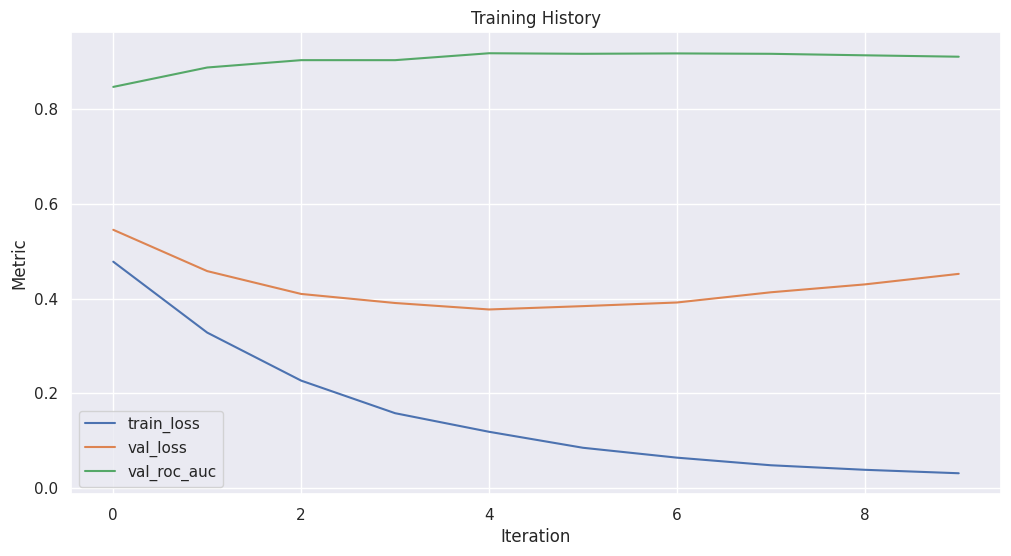

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9183
Test ROC-AUC 0.9163


In [ ]:
boosting = Boosting(
    n_estimators=100,
    early_stopping_rounds=5,
    subsample=0.8,
    bootstrap_type='Bernoulli',
    goss=True,
    goss_k=0.2,
    goss_subsample=0.3
)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')


### Работа с признаками

1. `rsm`

2. Uniform Quantile

Квантизация поможет в обработке выбросов и нанов. Выбросы оказывают меньшее влияние, так как их значения попадают в один из фиксированных бинов, а не остаются далекими от основного диапазона данных.

Наны можно ли просто заполнить каким-то числом,  но надо выбрать число очень далеким от реальных значений в данных

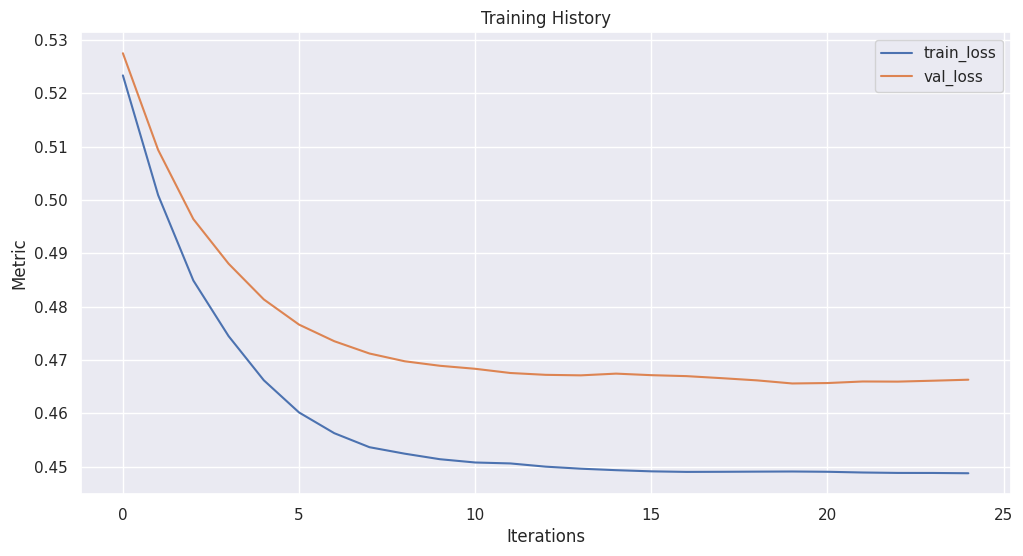

Train ROC-AUC: 0.9993
Valid ROC-AUC: 0.9244
Test ROC-AUC: 0.9178


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from typing import Optional, Union
import matplotlib.pyplot as plt


class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
        subsample: float = 1.0,
        bagging_temperature: float = 1.0,
        bootstrap_type: str = 'Bernoulli',
        rsm: Union[float, int] = 1.0,
        quantization_type: Optional[str] = None,
        nbins: int = 255,
    ):
        self.base_model_class = base_model_class
        self.base_model_params = {} if base_model_params is None else base_model_params
        self.n_estimators = n_estimators
        self.models = []
        self.gammas = []
        self.selected_features_for_models = []
        self.learning_rate = learning_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type
        self.rsm = rsm
        self.quantization_type = quantization_type
        self.nbins = nbins

        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _create_bootstrap_sample(self, X, y):
        n_samples = X.shape[0]

        if self.bootstrap_type == 'Bernoulli':
            mask = np.random.rand(n_samples) < self.subsample
            return X[mask], y[mask]

        else:
            weights = (-np.log(np.random.rand(n_samples))) ** self.bagging_temperature
            if hasattr(X, 'multiply'):
                X_weighted = X.multiply(weights[:, np.newaxis])
            else:
                X_weighted = X * weights[:, np.newaxis]

            y_weighted = y * weights
            return X_weighted, y_weighted

    def _select_features(self, n_features):
        if isinstance(self.rsm, float):
            n_selected = int(n_features * self.rsm)
        else:
            n_selected = min(n_features, self.rsm)
        return np.random.choice(n_features, size=n_selected, replace=False)

    def _quantize_features(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()

        if self.quantization_type == "uniform":
            min_vals, max_vals = np.min(X, axis=0), np.max(X, axis=0)
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                bins = np.linspace(min_vals[i], max_vals[i], self.nbins + 1)
                X_quantized[:, i] = np.digitize(X[:, i], bins, right=True) - 1
            return X_quantized

        elif self.quantization_type == "quantile":
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                quantiles = np.percentile(X[:, i], np.linspace(0, 100, self.nbins + 1))
                X_quantized[:, i] = np.digitize(X[:, i], quantiles, right=True) - 1
            return X_quantized

        return X


    def _find_optimal_gamma(self, y, old_predictions, new_predictions):
        gammas = np.linspace(0, 1, 100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def partial_fit(self, X, y):
        X_bootstrap, y_bootstrap = self._create_bootstrap_sample(X, y)
        n_features = X.shape[1]
        selected_features = self._select_features(n_features)

        if hasattr(X_bootstrap, "toarray"):
            X_bootstrap = X_bootstrap.toarray()

        X_selected = X_bootstrap[:, selected_features]


        X_selected = self._quantize_features(X_selected)

        residuals = y_bootstrap - self.sigmoid(np.zeros(len(y_bootstrap)))
        model = self.base_model_class(**self.base_model_params)
        model.fit(X_selected, residuals)

        model_predictions = model.predict(X_selected)
        gamma = self._find_optimal_gamma(y_bootstrap, np.zeros(len(y_bootstrap)), model_predictions)

        self.models.append((model, selected_features))
        self.gammas.append(gamma)

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])
        for model, gamma in zip(self.models, self.gammas):
            selected_features = model[1]
            if hasattr(X, "toarray"):
                X = X.toarray()
            X_selected = X[:, selected_features]
            X_selected = self._quantize_features(X_selected)
            predictions += gamma * model[0].predict(X_selected)
        probabilities = self.sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])


    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        if hasattr(X_train, "toarray"):
            X_train = X_train.toarray()
        if X_val is not None and hasattr(X_val, "toarray"):
            X_val = X_val.toarray()

        train_predictions = np.zeros(len(y_train))
        val_predictions = np.zeros(len(y_val)) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for _ in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions = self.predict_proba(X_train)[:, 1]
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions = self.predict_proba(X_val)[:, 1]
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds and rounds_without_improvement >= self.early_stopping_rounds:
                    break

        if plot:
            self.plot_history()


    def plot_history(self):
        plt.figure(figsize=(12, 6))
        for key, values in self.history.items():
            plt.plot(values, label=key)
        plt.xlabel("Iterations")
        plt.ylabel("Metric")
        plt.legend()
        plt.title("Training History")
        plt.show()

    def score(self, X, y):
        return roc_auc_score(y, self.predict_proba(X)[:, 1])


boosting = Boosting(
    n_estimators=100,
    early_stopping_rounds=5,
    subsample=0.8,
    bootstrap_type='Bernoulli',
    rsm=0.7,
    quantization_type='uniform',
    nbins=128
)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators
assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f"Train ROC-AUC: {boosting.score(X_train, y_train):.4f}")
print(f"Valid ROC-AUC: {boosting.score(X_valid, y_valid):.4f}")
print(f"Test ROC-AUC: {boosting.score(X_test, y_test):.4f}")


### feature_importances

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from typing import Optional, Union
import matplotlib.pyplot as plt


class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
        subsample: float = 1.0,
        bagging_temperature: float = 1.0,
        bootstrap_type: str = 'Bernoulli',
        rsm: Union[float, int] = 1.0,
        quantization_type: Optional[str] = None,
        nbins: int = 255,
    ):
        self.base_model_class = base_model_class
        self.base_model_params = {} if base_model_params is None else base_model_params
        self.n_estimators = n_estimators
        self.models = []
        self.gammas = []
        self.selected_features_for_models = []
        self.learning_rate = learning_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type
        self.rsm = rsm
        self.quantization_type = quantization_type
        self.nbins = nbins

        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _create_bootstrap_sample(self, X, y):
        n_samples = X.shape[0]

        if self.bootstrap_type == 'Bernoulli':
            mask = np.random.rand(n_samples) < self.subsample
            return X[mask], y[mask]

        else:
            weights = (-np.log(np.random.rand(n_samples))) ** self.bagging_temperature
            if hasattr(X, 'multiply'):
                X_weighted = X.multiply(weights[:, np.newaxis])
            else:
                X_weighted = X * weights[:, np.newaxis]

            y_weighted = y * weights
            return X_weighted, y_weighted

    def _select_features(self, n_features):
        if isinstance(self.rsm, float):
            n_selected = int(n_features * self.rsm)
        else:
            n_selected = min(n_features, self.rsm)
        return np.random.choice(n_features, size=n_selected, replace=False)

    def _quantize_features(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()

        if self.quantization_type == "uniform":
            min_vals, max_vals = np.min(X, axis=0), np.max(X, axis=0)
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                bins = np.linspace(min_vals[i], max_vals[i], self.nbins + 1)
                X_quantized[:, i] = np.digitize(X[:, i], bins, right=True) - 1
            return X_quantized

        elif self.quantization_type == "quantile":
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                quantiles = np.percentile(X[:, i], np.linspace(0, 100, self.nbins + 1))
                X_quantized[:, i] = np.digitize(X[:, i], quantiles, right=True) - 1
            return X_quantized

        return X


    def _find_optimal_gamma(self, y, old_predictions, new_predictions):
        gammas = np.linspace(0, 1, 100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def partial_fit(self, X, y):
        X_bootstrap, y_bootstrap = self._create_bootstrap_sample(X, y)
        n_features = X.shape[1]
        selected_features = self._select_features(n_features)

        if hasattr(X_bootstrap, "toarray"):
            X_bootstrap = X_bootstrap.toarray()

        X_selected = X_bootstrap[:, selected_features]


        X_selected = self._quantize_features(X_selected)

        residuals = y_bootstrap - self.sigmoid(np.zeros(len(y_bootstrap)))
        model = self.base_model_class(**self.base_model_params)
        model.fit(X_selected, residuals)

        model_predictions = model.predict(X_selected)
        gamma = self._find_optimal_gamma(y_bootstrap, np.zeros(len(y_bootstrap)), model_predictions)

        self.models.append((model, selected_features))
        self.gammas.append(gamma)

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])
        for model, gamma in zip(self.models, self.gammas):
            selected_features = model[1]
            if hasattr(X, "toarray"):
                X = X.toarray()
            X_selected = X[:, selected_features]
            X_selected = self._quantize_features(X_selected)
            predictions += gamma * model[0].predict(X_selected)
        probabilities = self.sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])


    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        if hasattr(X_train, "toarray"):
            X_train = X_train.toarray()
        if X_val is not None and hasattr(X_val, "toarray"):
            X_val = X_val.toarray()

        train_predictions = np.zeros(len(y_train))
        val_predictions = np.zeros(len(y_val)) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for _ in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_predictions = self.predict_proba(X_train)[:, 1]
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions = self.predict_proba(X_val)[:, 1]
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds and rounds_without_improvement >= self.early_stopping_rounds:
                    break

        if plot:
            self.plot_history()


    def plot_history(self):
        plt.figure(figsize=(12, 6))
        for key, values in self.history.items():
            plt.plot(values, label=key)
        plt.xlabel("Iterations")
        plt.ylabel("Metric")
        plt.legend()
        plt.title("Training History")
        plt.show()

    def score(self, X, y):
        return roc_auc_score(y, self.predict_proba(X)[:, 1])

    @property

    def feature_importances_(self):

        total_features = max(
            max(selected_features) for _, selected_features in self.models
        ) + 1
        feature_importances = np.zeros(total_features)

        for model, selected_features in self.models:
            tree_importances = model.feature_importances_
            for idx, feature_idx in enumerate(selected_features):
                feature_importances[feature_idx] += tree_importances[idx]

        if np.sum(feature_importances) > 0:
            feature_importances /= np.sum(feature_importances)
        return feature_importances


    def show_feature_importances(self, feature_names=None, top_n=10):

        importances = self.feature_importances_
        total_features = len(importances)

        if feature_names is None or len(feature_names) < total_features:
            feature_names = [f"Feature {i}" for i in range(total_features)]

        sorted_indices = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_indices][:top_n]
        sorted_feature_names = [feature_names[i] for i in sorted_indices[:top_n]]

        plt.figure(figsize=(10, 6))
        plt.barh(sorted_feature_names, sorted_importances, align="center")
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Feature Importances")
        plt.gca().invert_yaxis()
        plt.show()

        for i, (name, importance) in enumerate(zip(sorted_feature_names, sorted_importances), 1):
            print(f"{i}. {name}: {importance:.4f}")




boosting = Boosting(
    n_estimators=100,
    early_stopping_rounds=5,
    subsample=0.8,
    bootstrap_type='Bernoulli',
    rsm=0.7,
    quantization_type='uniform',
    nbins=128
)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid)

assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators
assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

importances = boosting.feature_importances_
print("Feature Importances:", importances)


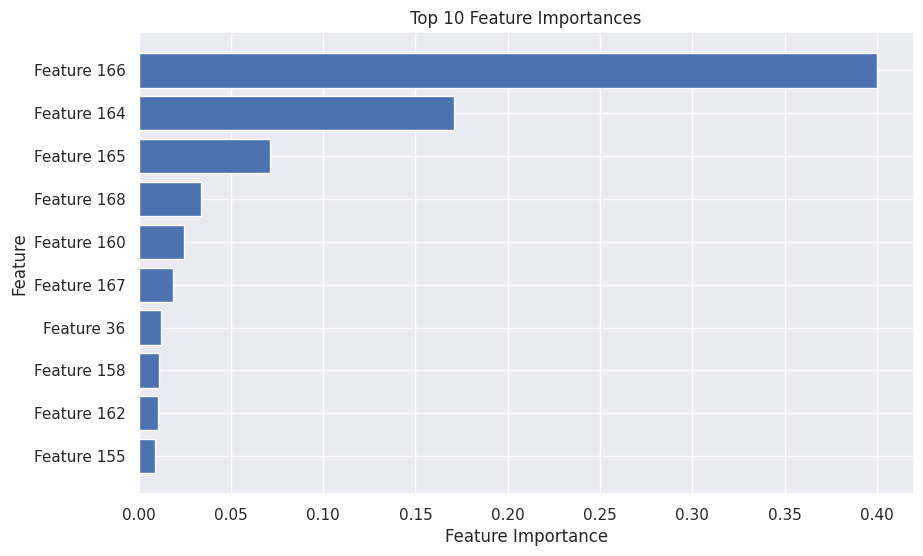

1. Feature 166: 0.3999
2. Feature 164: 0.1709
3. Feature 165: 0.0710
4. Feature 168: 0.0339
5. Feature 160: 0.0246
6. Feature 167: 0.0187
7. Feature 36: 0.0122
8. Feature 158: 0.0111
9. Feature 162: 0.0106
10. Feature 155: 0.0090


In [ ]:

boosting.show_feature_importances(feature_names=[f"Feature {i}" for i in range(len(boosting.feature_importances_))], top_n=10)


###  DART

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from typing import Optional, Union
import matplotlib.pyplot as plt


class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = None,
        subsample: float = 1.0,
        bagging_temperature: float = 1.0,
        bootstrap_type: str = 'Bernoulli',
        rsm: Union[float, int] = 1.0,
        quantization_type: Optional[str] = None,
        nbins: int = 255,
        dart: bool = False,
        dropout_rate: float = 0.05,
    ):
        self.base_model_class = base_model_class
        self.base_model_params = {} if base_model_params is None else base_model_params
        self.n_estimators = n_estimators
        self.models = []
        self.gammas = []
        self.selected_features_for_models = []
        self.learning_rate = learning_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type
        self.rsm = rsm
        self.quantization_type = quantization_type
        self.nbins = nbins
        self.dart = dart
        self.dropout_rate = dropout_rate

        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _create_bootstrap_sample(self, X, y):
        n_samples = X.shape[0]

        if self.bootstrap_type == 'Bernoulli':
            mask = np.random.rand(n_samples) < self.subsample
            return X[mask], y[mask]
        else:
            weights = (-np.log(np.random.rand(n_samples))) ** self.bagging_temperature
            if hasattr(X, 'multiply'):
                X_weighted = X.multiply(weights[:, np.newaxis])
            else:
                X_weighted = X * weights[:, np.newaxis]

            y_weighted = y * weights
            return X_weighted, y_weighted

    def _select_features(self, n_features):
        if isinstance(self.rsm, float):
            n_selected = int(n_features * self.rsm)
        else:
            n_selected = min(n_features, self.rsm)
        return np.random.choice(n_features, size=n_selected, replace=False)

    def _quantize_features(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()

        if self.quantization_type == "uniform":
            min_vals, max_vals = np.min(X, axis=0), np.max(X, axis=0)
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                bins = np.linspace(min_vals[i], max_vals[i], self.nbins + 1)
                X_quantized[:, i] = np.digitize(X[:, i], bins, right=True) - 1
            return X_quantized

        elif self.quantization_type == "quantile":
            X_quantized = np.zeros_like(X)
            for i in range(X.shape[1]):
                quantiles = np.percentile(X[:, i], np.linspace(0, 100, self.nbins + 1))
                X_quantized[:, i] = np.digitize(X[:, i], quantiles, right=True) - 1
            return X_quantized

        return X

    def _find_optimal_gamma(self, y, old_predictions, new_predictions):
        gammas = np.linspace(0, 1, 100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])
        for model, gamma in zip(self.models, self.gammas):
            selected_features = model[1]
            if hasattr(X, "toarray"):
                X = X.toarray()
            X_selected = X[:, selected_features]
            X_selected = self._quantize_features(X_selected)
            predictions += gamma * model[0].predict(X_selected)
        probabilities = self.sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])

    def partial_fit(self, X, y, current_predictions):
        X_bootstrap, y_bootstrap = self._create_bootstrap_sample(X, y)
        n_features = X.shape[1]
        selected_features = self._select_features(n_features)

        if hasattr(X_bootstrap, "toarray"):
            X_bootstrap = X_bootstrap.toarray()

        X_selected = X_bootstrap[:, selected_features]
        X_selected = self._quantize_features(X_selected)

        bootstrap_indices = np.flatnonzero((X_bootstrap != 0).any(axis=1))
        residuals = y_bootstrap - self.sigmoid(current_predictions[bootstrap_indices])

        model = self.base_model_class(**self.base_model_params)
        model.fit(X_selected, residuals)

        model_predictions = model.predict(X_selected)
        gamma = self._find_optimal_gamma(y_bootstrap, current_predictions[bootstrap_indices], model_predictions)

        self.models.append((model, selected_features))
        self.gammas.append(gamma)


    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        if hasattr(X_train, "toarray"):
            X_train = X_train.toarray()
        if X_val is not None and hasattr(X_val, "toarray"):
            X_val = X_val.toarray()

        train_predictions = np.zeros(len(y_train))
        val_predictions = np.zeros(len(y_val)) if X_val is not None else None

        best_val_loss = float('inf')
        rounds_without_improvement = 0

        for _ in range(self.n_estimators):
            if self.dart and self.models:
                dropped_trees = np.random.rand(len(self.models)) < self.dropout_rate
                retained_models = [model for i, model in enumerate(self.models) if not dropped_trees[i]]
                dropped_count = sum(dropped_trees)

                if dropped_count > 0:
                    train_predictions = sum(
                        gamma * model[0].predict(self._quantize_features(X_train[:, model[1]]))
                        for model, gamma in zip(retained_models, self.gammas) if model
                    )
                    train_predictions *= len(self.models) / len(retained_models)
            else:
                train_predictions = np.zeros(len(y_train))

            self.partial_fit(X_train, y_train, train_predictions)

            train_predictions = self.predict_proba(X_train)[:, 1]
            self.history["train_loss"].append(self.loss_fn(y_train, train_predictions))

            if X_val is not None:
                val_predictions = self.predict_proba(X_val)[:, 1]
                val_loss = self.loss_fn(y_val, val_predictions)
                self.history["val_loss"].append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if self.early_stopping_rounds and rounds_without_improvement >= self.early_stopping_rounds:
                    break

        if plot:
            self.plot_history()

    def plot_history(self):
        plt.figure(figsize=(12, 6))
        for key, values in self.history.items():
            plt.plot(values, label=key)
        plt.xlabel("Iterations")
        plt.ylabel("Metric")
        plt.legend()
        plt.title("Training History")
        plt.show()

    def score(self, X, y):
        return roc_auc_score(y, self.predict_proba(X)[:, 1])


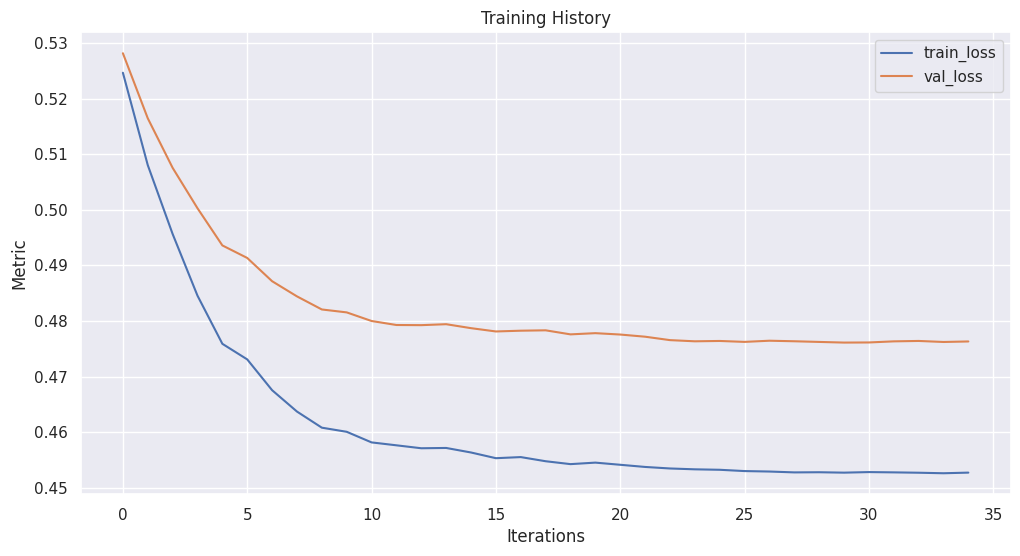

Train ROC-AUC 0.9992
Valid ROC-AUC 0.9228
Test ROC-AUC 0.9226


In [ ]:
boosting = Boosting(
    n_estimators=100,
    early_stopping_rounds=5,
    subsample=0.8,
    bootstrap_type='Bernoulli',
    rsm=0.7,
    quantization_type='uniform',
    nbins=128,
    dart=True,
    dropout_rate=0.1
)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)
assert len(boosting.models) <= boosting.n_estimators
assert len(boosting.gammas) <= boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

------

##  Оптимизация (3.5 балла + 0.5 бонус)

###  optuna

подбираем:
- `max_depth`
- `n_estimators`
- `learning_rate`

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "rsm": trial.suggest_float("rsm", 0.5, 0.95),
    }

    model = Boosting(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        base_model_params={"max_depth": params["max_depth"]},
        rsm=params["rsm"],
    )

    model.fit(X_train, y_train, X_val=X_valid, y_val=y_valid)
    val_auc = model.score(X_valid, y_valid)

    return val_auc

study = optuna.create_study(direction="maximize", study_name="Boosting Hyperparameter Optimization")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation ROC-AUC:", study.best_value)


Best Parameters: {'n_estimators': 30, 'learning_rate': 0.0774513525467087, 'max_depth': 7, 'rsm': 0.7110216824847495}
Best Validation ROC-AUC: 0.9392708365759842

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study).show()


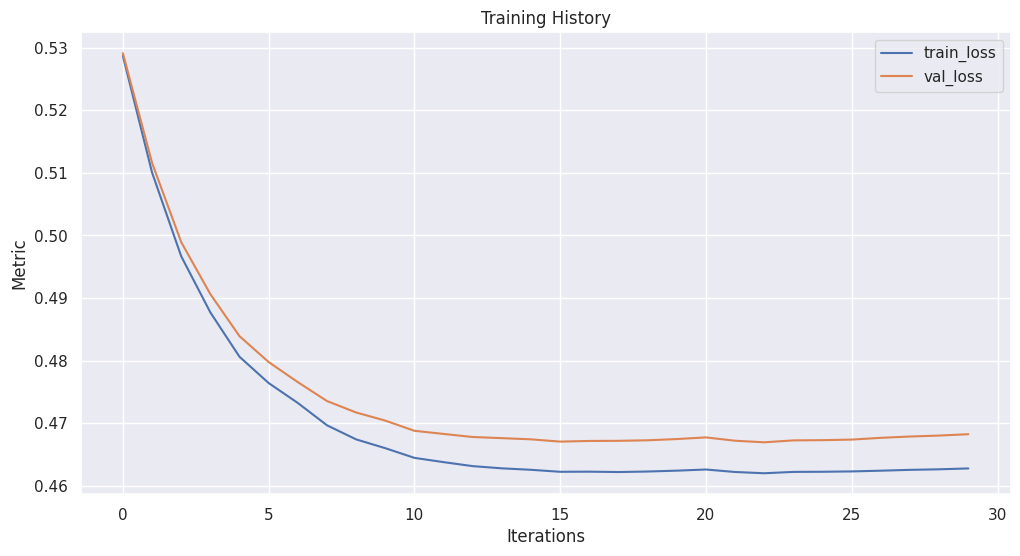

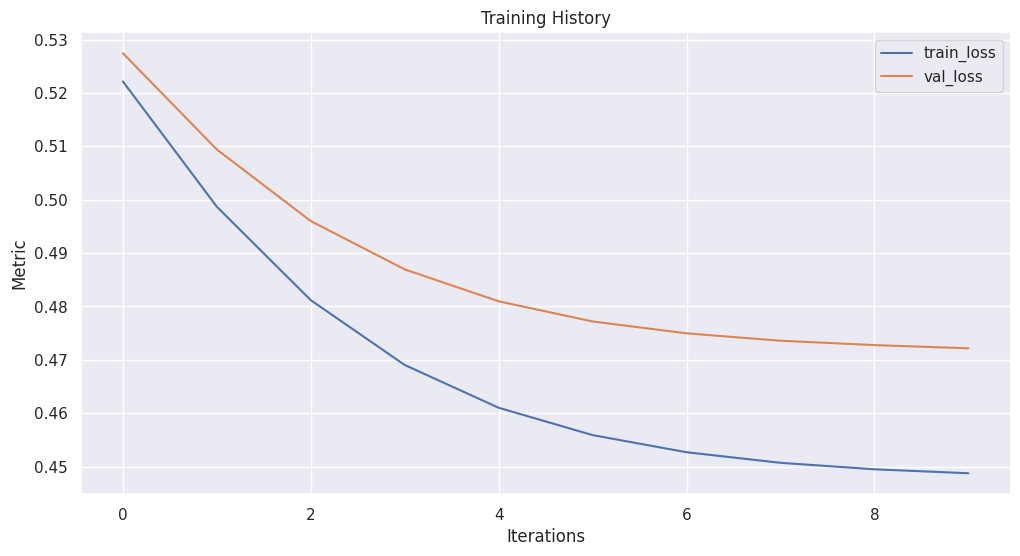

Default Model Validation ROC-AUC: 0.8591
Optimized Model Validation ROC-AUC: 0.9380


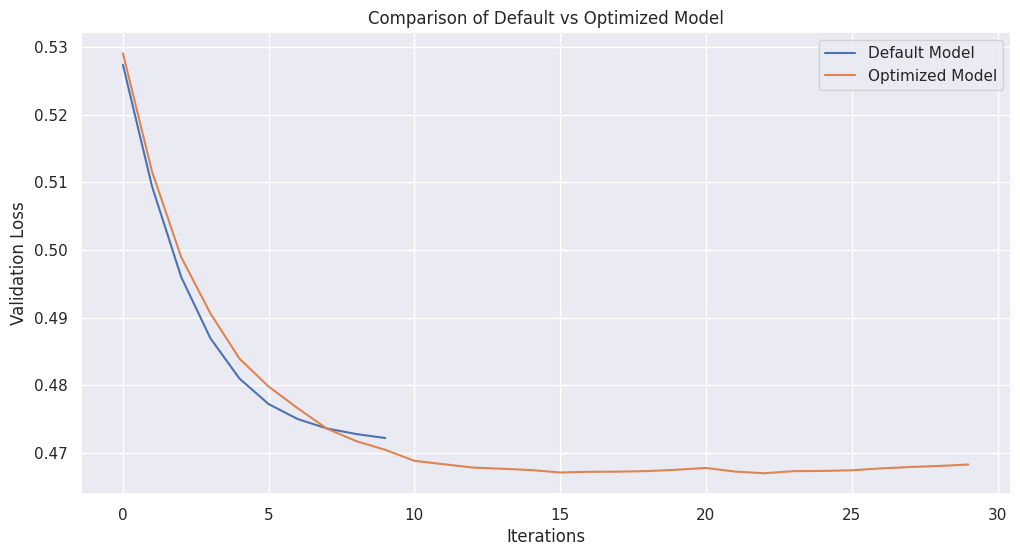

In [ ]:

best_params = study.best_params
optimized_model = Boosting(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    base_model_params={"max_depth": best_params["max_depth"]},
    rsm=best_params["rsm"],
)
optimized_model.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

default_model = Boosting()
default_model.fit(X_train, y_train, X_val=X_valid, y_val=y_valid, plot=True)

print(f"Default Model Validation ROC-AUC: {default_model.score(X_valid, y_valid):.4f}")
print(f"Optimized Model Validation ROC-AUC: {optimized_model.score(X_valid, y_valid):.4f}")

plt.figure(figsize=(12, 6))
plt.plot(default_model.history["val_loss"], label="Default Model")
plt.plot(optimized_model.history["val_loss"], label="Optimized Model")
plt.xlabel("Iterations")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Comparison of Default vs Optimized Model")
plt.show()



Запись в хранилища, прунер, сохранение истории функции потерь и времени обучения

In [ ]:
import time
import optuna
from optuna.pruners import MedianPruner
from optuna.study import StudyDirection
from sklearn.model_selection import train_test_split

def objective(trial):

    start_time = time.time()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "rsm": trial.suggest_float("rsm", 0.5, 0.95),
    }

    model = Boosting(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        base_model_params={"max_depth": params["max_depth"]},
        rsm=params["rsm"]
    )

    val_losses = []

    for iteration in range(params["n_estimators"]):
        model.partial_fit(X_train, y_train)
        val_loss = model.loss_fn(y_valid, model.predict_proba(X_valid)[:, 1])
        val_losses.append(val_loss)

        trial.report(val_loss, iteration)
        if trial.should_prune():
            raise optuna.TrialPruned()

    val_auc = model.score(X_valid, y_valid)

    trial.set_user_attr("val_losses", val_losses)
    trial.set_user_attr("training_time", time.time() - start_time)

    return val_auc

storage = "sqlite:///optuna_boosting.db"
study = optuna.create_study(
    direction="maximize",
    storage=storage,
    study_name="Boosting Optimization",
    load_if_exists=True,
    pruner=MedianPruner()
)

study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation ROC-AUC:", study.best_value)



Best Parameters: {'n_estimators': 28, 'learning_rate': 0.020841233677633762, 'max_depth': 7, 'rsm': 0.5212893468233408}


Best Validation ROC-AUC: 0.9375164128020255

Оптимизация значительно ускорилась

###  Готовые реализации

In [ ]:
!pip install catboost optuna


In [ ]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import time

storage = "sqlite:///optuna_boosting.db"
study = optuna.load_study(study_name="Boosting Optimization", storage=storage)

best_params_custom = study.best_params
print("Лучшие параметры для кастомного бустинга:", best_params_custom)

model_custom = Boosting(
    n_estimators=best_params_custom["n_estimators"],
    learning_rate=best_params_custom["learning_rate"],
    base_model_params={"max_depth": best_params_custom["max_depth"]},
    rsm=best_params_custom["rsm"]
)

start_time_custom = time.time()
model_custom.fit(X_train, y_train, X_val=X_valid, y_val=y_valid)
time_custom = time.time() - start_time_custom

roc_auc_custom_train = model_custom.score(X_train, y_train)
roc_auc_custom_valid = model_custom.score(X_valid, y_valid)
roc_auc_custom_test = model_custom.score(X_test, y_test)

print(f"ROC-AUC для кастомного бустинга:")
print(f"  Обучающая выборка: {roc_auc_custom_train:.4f}")
print(f"  Валидационная выборка: {roc_auc_custom_valid:.4f}")
print(f"  Тестовая выборка: {roc_auc_custom_test:.4f}")

def objective_catboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "rsm": trial.suggest_float("rsm", 0.5, 0.95),
    }

    model = CatBoostClassifier(
        **params,
        eval_metric="AUC",
        random_seed=42,
        logging_level="Silent"
    )

    model.fit(
        Pool(X_train, y_train),
        eval_set=Pool(X_valid, y_valid),
        early_stopping_rounds=10
    )

    return model.best_score_["validation"]["AUC"]

study_catboost = optuna.create_study(direction="maximize", study_name="CatBoost Optimization")
study_catboost.optimize(objective_catboost, n_trials=50)

best_params_cb = study_catboost.best_params
print("Лучшие параметры для CatBoost:", best_params_cb)

cb_model = CatBoostClassifier(**best_params_cb, random_seed=42, logging_level="Silent")
start_time_cb = time.time()
cb_model.fit(Pool(X_train, y_train), eval_set=Pool(X_valid, y_valid))
time_cb = time.time() - start_time_cb

roc_auc_cb_train = cb_model.score(Pool(X_train, y_train))
roc_auc_cb_valid = cb_model.score(Pool(X_valid, y_valid))
roc_auc_cb_test = cb_model.score(Pool(X_test, y_test))

print(f"ROC-AUC для CatBoost:")
print(f"  Обучающая выборка: {roc_auc_cb_train:.4f}")
print(f"  Валидационная выборка: {roc_auc_cb_valid:.4f}")
print(f"  Тестовая выборка: {roc_auc_cb_test:.4f}")

print(f"Время обучения кастомного бустинга: {time_custom:.2f} секунд")
print(f"Время обучения CatBoost: {time_cb:.2f} секунд")


Лучшие параметры для кастомного бустинга: {'n_estimators': 28, 'learning_rate': 0.020841233677633762, 'max_depth': 7, 'rsm': 0.5212893468233408}

[I 2024-12-23 12:13:35,223] A new study created in memory with name: CatBoost Optimization

ROC-AUC для кастомного бустинга:

  Обучающая выборка: 0.9710

  Валидационная выборка: 0.9395

  Тестовая выборка: 0.9350

  Лучшие параметры для CatBoost: {'n_estimators': 25, 'learning_rate': 0.2403493777288763, 'max_depth': 7, 'rsm': 0.8759233003068703}

ROC-AUC для CatBoost:

  Обучающая выборка: 0.9150

  Валидационная выборка: 0.8789

  Тестовая выборка: 0.8708

Время обучения кастомного бустинга: 21.75 секунд

Время обучения CatBoost: 0.30 секунд

In [ ]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import time
import numpy as np

storage = "sqlite:///optuna_boosting.db"
study = optuna.load_study(study_name="Boosting Optimization", storage=storage)

best_params_custom = study.best_params
print("Лучшие параметры для кастомного бустинга:", best_params_custom)

model_custom = Boosting(
    n_estimators=best_params_custom["n_estimators"],
    learning_rate=best_params_custom["learning_rate"],
    base_model_params={"max_depth": best_params_custom["max_depth"]},
    rsm=best_params_custom["rsm"]
)

start_time_custom = time.time()
model_custom.fit(X_train, y_train, X_val=X_valid, y_val=y_valid)
time_custom = time.time() - start_time_custom

val_losses_custom = study.best_trial.user_attrs["val_losses"]

def objective_catboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "rsm": trial.suggest_float("rsm", 0.5, 0.95),
    }

    model = CatBoostClassifier(**params, random_seed=42, logging_level="Silent")
    model.fit(Pool(X_train, y_train), eval_set=Pool(X_valid, y_valid), early_stopping_rounds=10)
    return model.best_score_["validation"]["Logloss"]

study_catboost = optuna.create_study(direction="minimize", study_name="CatBoost Optimization")
study_catboost.optimize(objective_catboost, n_trials=50)

best_params_cb = study_catboost.best_params
print("Лучшие параметры для CatBoost:", best_params_cb)

cb_model = CatBoostClassifier(**best_params_cb, random_seed=42, logging_level="Silent")
start_time_cb = time.time()
cb_model.fit(Pool(X_train, y_train), eval_set=Pool(X_valid, y_valid), plot=True)
time_cb = time.time() - start_time_cb

val_losses_cb = cb_model.evals_result_["validation"]["Logloss"]

plt.figure(figsize=(12, 6))
plt.plot(val_losses_custom, label="Custom Boosting Validation Loss")
plt.plot(val_losses_cb, label="CatBoost Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison of Loss Dynamics")
plt.show()

print(f"Время обучения кастомного бустинга: {time_custom:.2f} секунд")
print(f"Время обучения CatBoost: {time_cb:.2f} секунд")


Лучшие параметры для кастомного бустинга: {'n_estimators': 28, 'learning_rate': 0.020841233677633762, 'max_depth': 7, 'rsm': 0.5212893468233408}

Лучшие параметры для CatBoost: {'n_estimators': 22, 'learning_rate': 0.2924295861710214, 'max_depth': 6, 'rsm': 0.8140198586488079}

Время обучения кастомного бустинга: 22.16 секунд

Время обучения CatBoost: 0.27 секунд

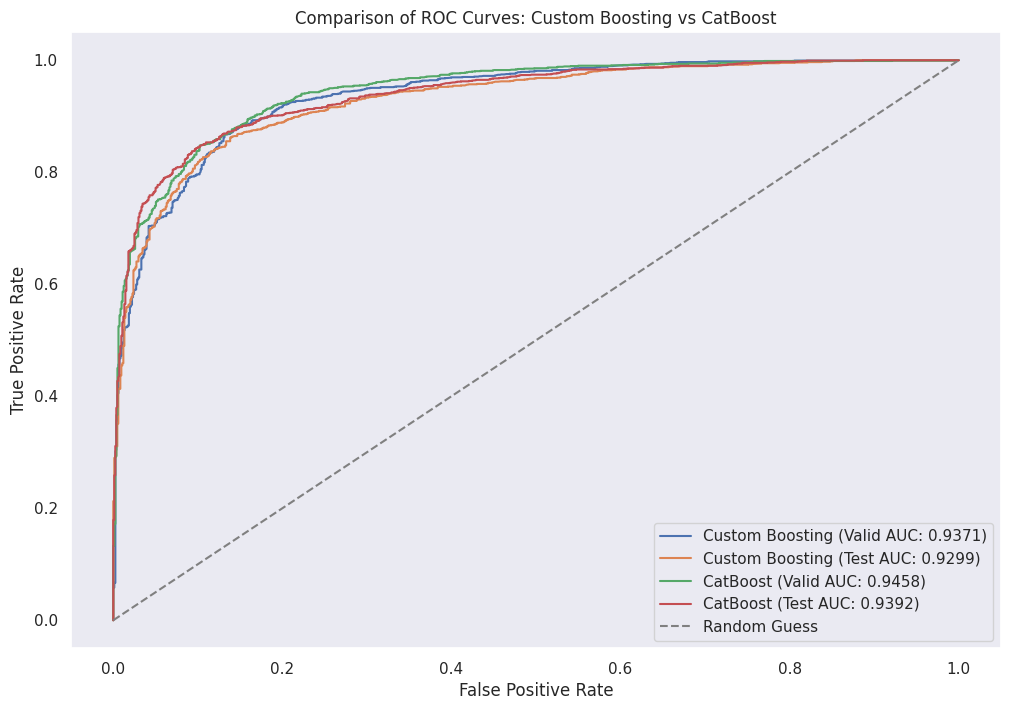

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

y_train_proba_custom = model_custom.predict_proba(X_train)[:, 1]
y_valid_proba_custom = model_custom.predict_proba(X_valid)[:, 1]
y_test_proba_custom = model_custom.predict_proba(X_test)[:, 1]

y_train_proba_cb = cb_model.predict_proba(X_train)[:, 1]
y_valid_proba_cb = cb_model.predict_proba(X_valid)[:, 1]
y_test_proba_cb = cb_model.predict_proba(X_test)[:, 1]

fpr_train_custom, tpr_train_custom, _ = roc_curve(y_train, y_train_proba_custom)
fpr_valid_custom, tpr_valid_custom, _ = roc_curve(y_valid, y_valid_proba_custom)
fpr_test_custom, tpr_test_custom, _ = roc_curve(y_test, y_test_proba_custom)

auc_train_custom = auc(fpr_train_custom, tpr_train_custom)
auc_valid_custom = auc(fpr_valid_custom, tpr_valid_custom)
auc_test_custom = auc(fpr_test_custom, tpr_test_custom)

fpr_train_cb, tpr_train_cb, _ = roc_curve(y_train, y_train_proba_cb)
fpr_valid_cb, tpr_valid_cb, _ = roc_curve(y_valid, y_valid_proba_cb)
fpr_test_cb, tpr_test_cb, _ = roc_curve(y_test, y_test_proba_cb)

auc_train_cb = auc(fpr_train_cb, tpr_train_cb)
auc_valid_cb = auc(fpr_valid_cb, tpr_valid_cb)
auc_test_cb = auc(fpr_test_cb, tpr_test_cb)

plt.figure(figsize=(12, 8))

plt.plot(fpr_valid_custom, tpr_valid_custom, label=f"Custom Boosting (Valid AUC: {auc_valid_custom:.4f})")
plt.plot(fpr_test_custom, tpr_test_custom, label=f"Custom Boosting (Test AUC: {auc_test_custom:.4f})")

plt.plot(fpr_valid_cb, tpr_valid_cb, label=f"CatBoost (Valid AUC: {auc_valid_cb:.4f})")
plt.plot(fpr_test_cb, tpr_test_cb, label=f"CatBoost (Test AUC: {auc_test_cb:.4f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

plt.title("Comparison of ROC Curves: Custom Boosting vs CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


CatBoost быстрее и дает лучшее качество


CatBoost, так как дает хорошие результаты и не требует тонкой настройки

### Бустинг и вероятности

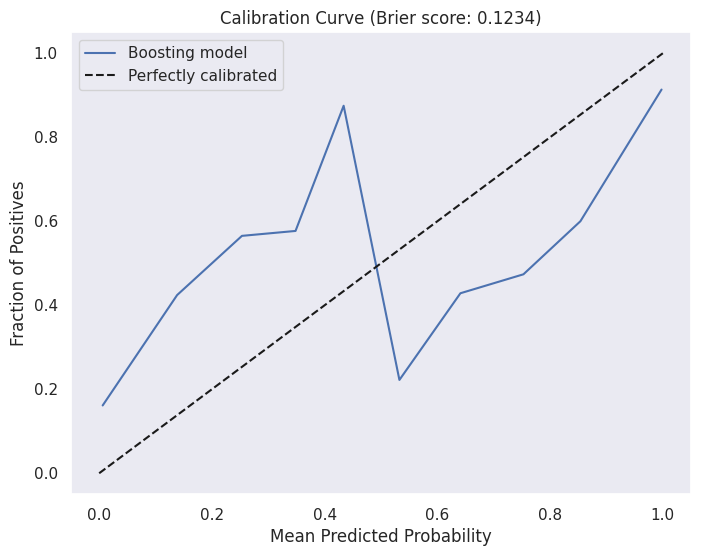

Brier Score: 0.1234


In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

y_prob = optimized_model.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

brier_score = brier_score_loss(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, label="Boosting model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title(f"Calibration Curve (Brier score: {brier_score:.4f})")
plt.legend()
plt.grid()
plt.show()

print(f"Brier Score: {brier_score:.4f}")


Оценка Брайера достаточно низкая, что говорит о том, что предсказанные вероятности модели не слишком далеки от истинных

